<a href="https://colab.research.google.com/github/ndtuan10/MachineLearning-and-ComputerVision/blob/main/CV/DoAn/Offline_Handwriting_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BÁO CÁO ĐỒ ÁN CUỐI KÌ**

**Môn : Thị giác máy tính nâng cao - CS331.L22.KHCL**

Giáo viên : TS.Mai Tiến Dũng

Thành viên :

  + Ngô Đức Tuấn (18520186)  
  + Lê Hoàng Long (18521027)

## Về đề tài
- **Tên tiếng Việt: Nhận diện tên được viết bằng tiếng Anh sử dụng các kỹ thuật học sâu.**
- **Tên tiếng Anh: Neuronal approaches for offline handwriting recognition.**
- Nguồn dữ liệu: Kaggle
- Link dữ liệu: https://www.kaggle.com/landlord/handwriting-recognition
- Mục tiêu: Nghiên cứu hướng tiếp cận bằng các kỹ thuật học sâu và áp dụng chúng để nhận diện tên riêng viết tay gồm các chữ cái trong bảng chữ cái tiếng Anh (30 ký tự) để chuyển ảnh tên riêng đó sang dạng text.
- Input: Ảnh 1 dòng chữ chứa tên riêng, các ký tự không bị che khuất bởi ngoại cảnh, chữ màu đen và background màu trắng.
- Output: Tên riêng dạng text.
- Thách thức:
    - Sự biến đổi (variability) và sự nhập nhằng (ambiguity) của các nét chữ từ người này sang người khác.
    - Phong cách viết tay của một cá nhân cũng có thể thay đổi theo thời gian và không nhất quán.
    - Các ký tự lệch ra khỏi hàng quá nhiều và quá thường xuyên.
    - Các ảnh trong dataset nhóm chọn đa phần chứa thông tin nhiễu (nội dung ngoài chữ viết tay) đòi hỏi phải detect riêng và loại bỏ. Ví dụ mẫu TRAIN_00001 ngoài tên riêng “BALTHAZAR” thì còn chứa các nội dung khác gây ảnh hưởng tới quá trình train và predict của model.


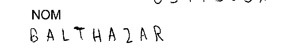

# **I. ĐỌC-HIỂU DỮ LIỆU**

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive')  

Mounted at /gdrive


## Import một số thư viện cần thiết

In [ ]:
import os
from os import listdir
import cv2
import random
import pandas as pd
import numpy as np
import glob
import tqdm
from typing import Dict
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
%matplotlib inline

## Download data từ Kaggle về Google Colab

- Để download Kaggle API JSON, đăng nhập Kaggle của bạn và tải API tại đây [Create New API Token].
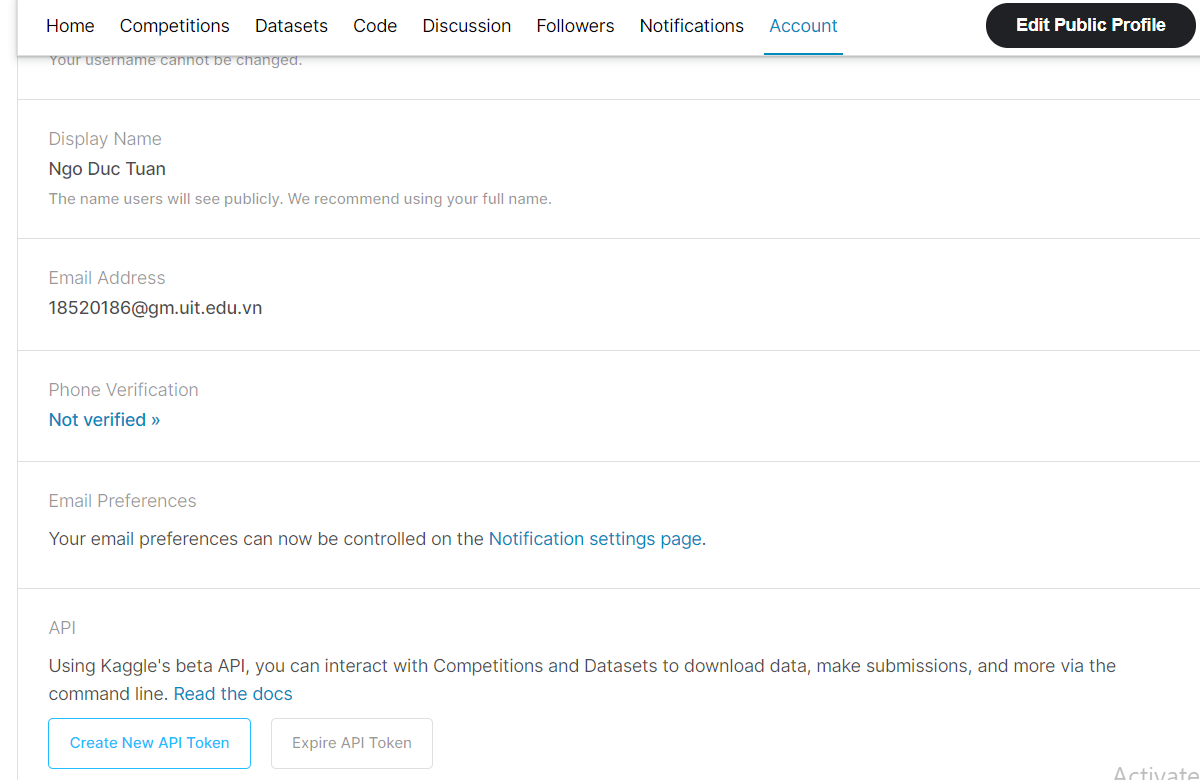

In [ ]:
# Check current location, '/content' is the Colab virtual machine
os.getcwd()
# Enable the Kaggle environment, use the path to the directory your Kaggle API JSON is stored in
os.environ['KAGGLE_CONFIG_DIR'] = '/gdrive/MyDrive/CS331 - 18520186 - 18521027/Kaggle'

In [ ]:
!pip install kaggle

In [ ]:
# Navigate into Drive where you want to store your Kaggle data
os.chdir('/gdrive/MyDrive/CS331 - 18520186 - 18521027/Kaggle')
# Paste and run the copied API command, the data will download to the current directory
!kaggle datasets download -d landlord/handwriting-recognition
# Check contents of directory, you should see the .zip file for the competition in your Drive
os.listdir()

 99% 1.25G/1.26G [00:10<00:00, 155MB/s]
100% 1.26G/1.26G [00:11<00:00, 121MB/s]


['kaggle.json', 'handwriting-recognition.zip']

- Chọn dataset của bạn và bấm copy API command, paste nó vào đường dẫn trên.
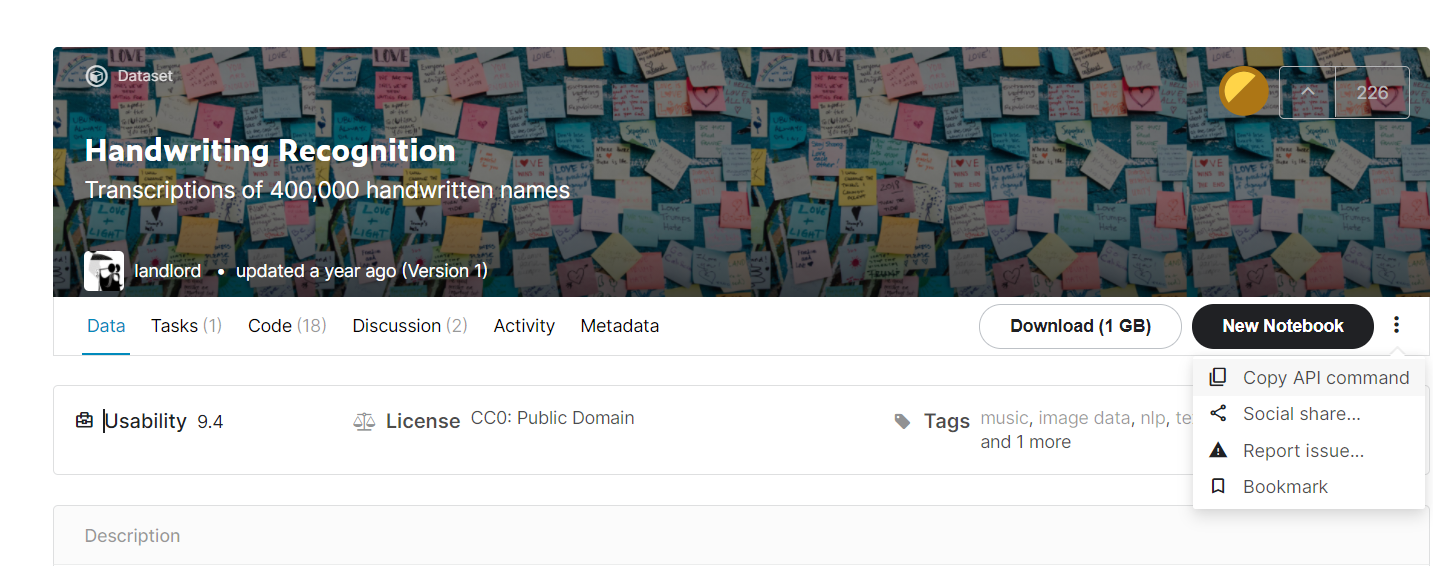

## Đọc dữ liệu

In [ ]:
# Complete path to storage location of the .zip file of data
zip_path = '/gdrive/MyDrive/CS331 - 18520186 - 18521027/Kaggle/handwriting-recognition.zip'
# Check current directory (be sure you're in the directory where Colab operates: '/content')
os.getcwd()
# Unzip quietly 
!unzip -q 'handwriting-recognition.zip'
# View the unzipped contents in the virtual machine
os.listdir()

['kaggle.json',
 'handwriting-recognition.zip',
 'test_v2',
 'train_v2',
 'validation_v2',
 'written_name_test_v2.csv',
 'written_name_train_v2.csv',
 'written_name_validation_v2.csv']

In [ ]:
import os
IMAGE_PATH = "/gdrive/MyDrive/CS331 - 18520186 - 18521027/Kaggle"

train = pd.read_csv('/gdrive/MyDrive/CS331 - 18520186 - 18521027/Kaggle/written_name_train_v2.csv')
val = pd.read_csv('/gdrive/MyDrive/CS331 - 18520186 - 18521027/Kaggle/written_name_validation_v2.csv')

print('Training data shape: ',train.shape) #Số dòng, số cột
print('Validation data shape: ',val.shape) # Số dòng, số cột

train.head(5)

Training data shape:  (330961, 2)
Validation data shape:  (41370, 2)


,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


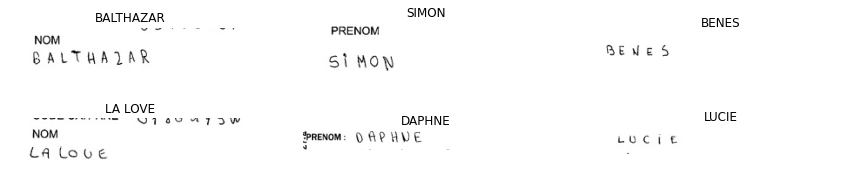

In [ ]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/gdrive/MyDrive/CS331 - 18520186 - 18521027/Kaggle/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

# **II. TIỀN XỬ LÝ DỮ LIỆU**

## Làm sạch dữ liệu (Data Cleaning)
- Trong phần làm sạch dữ liệu, ta tiến hành xử lí dữ liệu bị thiếu, tìm các dữ liệu không đọc được 'unreadable' do yếu tố bị che mờ, viết không rõ chữ, chỉnh các chữ về cùng kiều in hoa.

### Kiểm tra giá trị bị thiếu (Missing values)

In [ ]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", val['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


- Ở đây tập train có tổng cộng 565 ảnh bị thiếu giá trị nhãn và con số ở tập valid là 78. Vì số lượng dữ liệu ảnh của hai tập này lớn hơn nhiều, ta thấy nó không đáng kể, chiếm rất ít nên ta sẽ loại bỏ chúng.

In [ ]:
train.dropna(axis=0, inplace=True)
val.dropna(axis=0, inplace=True)

### Kiểm tra "Unreadable"
- Ngoài ra, có những ảnh trong data có chứa nhãn 'UNREADABLE'. Ta cũng kiểm tra những giá trị này và loại bỏ chúng.

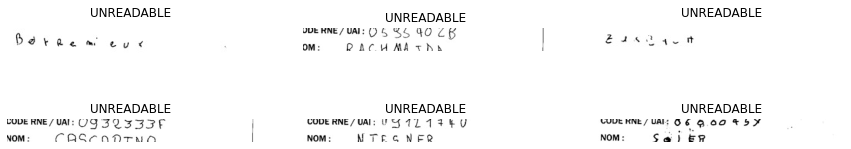

In [ ]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/gdrive/MyDrive/CS331 - 18520186 - 18521027/Kaggle/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
train = train[train['IDENTITY'] != 'UNREADABLE']
val = val[val['IDENTITY'] != 'UNREADABLE']

### LOWERCASE - UPPERCASE
- Có một số nhãn được viết bằng chữ thường. Để duy trì tính đồng nhất trong các nhãn, ta nên chuyển đổi tất cả các nhãn này thành chữ hoa (upper).

In [ ]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
val['IDENTITY'] = val['IDENTITY'].str.upper()

- Đánh lại index và chúng ta đã hoàn thành việc cleaning dữ liệu. 

In [ ]:
train.reset_index(inplace = True, drop=True) 
val.reset_index(inplace = True, drop=True)

- Xem lại shape của train và test sau khi xử lý

In [ ]:
print('Training data shape: ',train.shape)
print('Validation data shape: ',val.shape)

Training data shape:  (330294, 2)
Validation data shape:  (41280, 2)


- Lúc này tập training còn 330294 ảnh, và tập valid là 41280 ảnh

## Reshape kích thước ảnh đầu vào

- Ảnh được load dưới dạng grayscale và sẽ được reshape về chiều rộng = 256 và chiều cao = 64.
- Chiều rộng và chiều cao sẽ bị crop lại nếu chúng lớn hơn 256 và 64. Nếu chúng nhỏ hơn, thì hình ảnh sẽ được thêm các padding bằng các pixel màu trắng. Cuối cùng hình ảnh được rotate theo chiều kim đồng hồ để đưa hình ảnh về (x, y).
- Sau đó, chuẩn hóa các giá trị pixel của ảnh về dạng [0, 1] bằng cách chia cho 255.

In [ ]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

## Sử dụng tập train và valid dể huấn luyện
- Tôi sẽ sử dụng khoảng 10% của dữ liệu để huấn luyện, tức tương đương với 66000 ảnh của tập train và 8200 ảnh của tập validation

In [ ]:
train_size = 30000
val_size= 4000

In [ ]:
train_x = []

for i in range(train_size):
    img_dir = '/gdrive/MyDrive/CS331 - 18520186 - 18521027/Kaggle/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [ ]:
val_x = []

for i in range(val_size):
    img_dir = '/gdrive/MyDrive/CS331 - 18520186 - 18521027/Kaggle/validation_v2/validation/'+val.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    val_x.append(image)

In [ ]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
val_x = np.array(val_x).reshape(-1, 256, 64, 1)

## Chuẩn bị nhãn cho CTC loss

- Tìm hiểu thêm về hàm mất mát CTC và lý do tại sao nó tuyệt vời để nhận dạng văn bản từ đây.
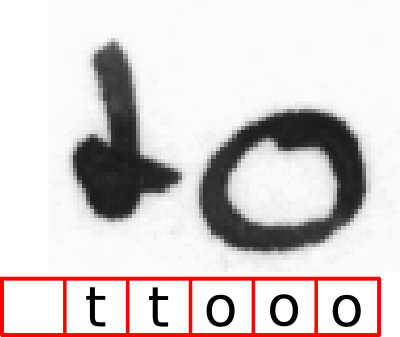

- Transcription là quá trình chuyển đổi các dự đoán trên mỗi khung được thực hiện bởi RNN thành một chuỗi nhãn. Transcription là để tìm chuỗi nhãn với xác suất cao nhất được điều chỉnh dựa trên các dự đoán trên mỗi khung. Trong phần này, các tác giả đã áp dụng xác suất có điều kiện với hàm mất mát là Connectionsist Temporal Classification (CTC). 
- Tại sao lại sử dụng CTC loss: 

    + Thông thường ta có thể chỉ định cho mỗi vị trí trục ngang của ảnh là kí tự tương ứng như trong Hình. Khi huấn luyện, đầu ra của RNN sẽ là ra điểm số (xác suất) của ký tự cho mỗi vị trí trên trục ngang. Tuy nhiên ta có vấn đề đó là rất tốn thời gian để annotate từng kí tự. Ta cần phải xử lý thêm để có được text cuối cùng của từ đó. Một ký tự có thể kéo dài nhiều vị trí theo trục ngang, giả sử ta có hình ảnh đầu vào với text là “to”, đầu ra của RNN là [‘t’, ‘t’, ‘o’, ‘o’, ‘o’]  do từ “o” nằm khá rộng so với trục ngang này. Ta cần phải loại bỏ đi các từ “t” và từ “o” trùng lặp. Do đó cần đến CTC loss.

	+ Để đưa ra dự đoán text đầu ra với từ mong muốn, Lúc này CTC sẽ giải quyết bằng cách gộp những kí tự giống nhau vào đồng thời thêm ký tự khoảng trắng giữa những ký tự giống nhau liên tục. Thì khi decode thì CTC sẽ xóa khỏi những kí tự khoảng trắng và cho ra kết quả đầu ra chính xác.


- Các nhãn được mã hóa từng ký tự của một từ thành một số trong tập huấn luyện bằng cách tạo một hàm theo 'Bảng chữ cái' bao gồm A-Z và ba ký tự đặc biệt (- 'và dấu cách) như sau  (như 'a': 0, 'b': 1 …… .. 'z': 26, v.v.). Giả sử chúng ta đang có từ 'abab' thì nhãn mã hóa của chúng ta sẽ là [0,1,0,1]

In [ ]:
alphabets = "ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # chiều dài tối đa của nhãn đầu vào
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # chiều dài tối đa của nhãn dự doắn


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [ ]:
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


- train_y chứa các nhãn đúng (true labels) được chuyển đổi thành số và được padded bằng -1. Chiều dài của mỗi nhãn bằng max_str_len.
- train_label_len chứa độ dài của mỗi nhãn true (không có padding)
- train_input_len chứa độ dài của mỗi nhãn được dự đoán. Chiều dài của tất cả các nhãn được dự đoán là không đổi, tức là số timestamps - 2.
- train_output là một dummy output cho ctc loss.

In [ ]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    

In [ ]:
val_y = np.ones([val_size, max_str_len]) * -1
val_label_len = np.zeros([val_size, 1])
val_input_len = np.ones([val_size, 1]) * (num_of_timestamps-2)
val_output = np.zeros([val_size])

for i in range(val_size):
    val_label_len[i] = len(val.loc[i, 'IDENTITY'])
    val_y[i, 0:len(val.loc[i, 'IDENTITY'])]= label_to_num(val.loc[i, 'IDENTITY'])    

In [ ]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


# **III. Thiết kế mô hình**

## CRNN

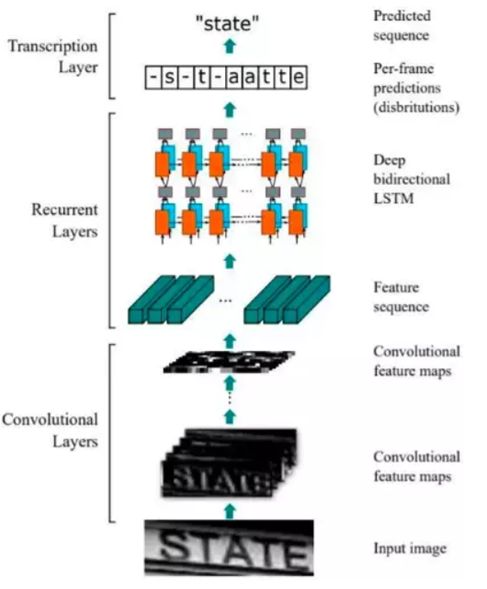

- Kiến trúc mạng của CRNN, như trong Hình trên, bao gồm ba thành phần chính theo thứ tự từ dưới lên trên như sau:
	1. Convolutional layers (Các lớp tích chập): Với các ảnh đầu vào được cho lớp CNN từ đó rút trích những đặc trưng, đầu ra của CNN layer là một feature map.

	2. Recurrent layers (Các lớp lặp lại): Feature map của lớp CNN được cung cấp như những chuỗi vào lớp recurrent. Recurrent layers bao gồm deep bidirectional LSTM networks. RNN có khả năng nắm bắt thông tin ngữ cảnh rất tốt trong mỗi chuỗi. Đầu ra từ lớp RNN sẽ bao gồm các giá trị xác suất cho mỗi nhãn tương ứng với mỗi đặc điểm đầu vào (input feature). 

	3. Transcription layers: Thành phần cuối cùng là transcription layer. Mặc dù CRNN bao gồm các loại kiến trúc mạng khác nhau (ví dụ: CNN và RNN), nó có thể được huấn luyện chung với một hàm mất mát mà cụ thể trong phần huấn luyện, chúng tôi sử đó là CTC loss để dự đoán đầu ra cho từng timesteps.

In [ ]:
# CNN
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 64)       256   

- Cách thiết kế mô hình CRNN
    + tại khối các lớp tích chập của mạng CNN
        + Input Layer: đầu vào ảnh có kích thước chung là (256, 64,1). Chúng tôi cho ảnh đầu vào có chiều cao là 256 và chiều rộng là 64.
        + Convolution Layer: tìm ra feature map đặc trưng quan trọng cho bài toán. Ở đây chúng tôi sử dụng 3 lớp tích chập kích thước kernel (3,3) kèm theo đó là số lượng filter tăng lên từ 32 lên 128 theo từng lớp. 
        + Pooling Layer: dùng để giảm kích thước dữ liệu. Hai lớp max-pooling được thêm vào với kích thước (2,2) và sau đó 1 lớp max-pooling với kích thước (1,2) được thêm vào để trích xuất các đối tượng ảnh có chiều dài lớn hơn. 
        + Ngoài ra chúng tôi còn dùng 3 lớp chuẩn hóa (batch normalization) sau mỗi lớp tích chập để tăng tốc quá trình huấn luyện. Ngoài ra, sau mỗi lớp tính chập ta thêm vào một lớp kích hoạt phi tuyến là ReLU
    + chuyển đổi từ CNN sang RNN
        + Để chuyển đổi từ CNN sang RNN ta sẽ reshape kích thước để ép đầu ra từ lớp Convolutional tương ứng với đầu vào của mạng LSTM. Đầu ra của lớp CNN chính là các feature map.
    + tại khối các lớp lặp lại của mạng RNN
        + Ở RNN chúng tôi sử dụng 2 Bidirectional LSTM layers với mỗi layer là 256 units. 
        + Tại ouptut ta có kích thước của các dự đoán là (64, 30). Mô hình dự đoán các từ gồm 64 kí tự và mỗi kí tự chứa xác suất của 30 chữ cái trong bảng tiếng Anh mà mình đã xác định trước đó. Do ta muốn đưa ra được phân bố xác suất để dự đoán các từ do đó ta kèm theo một hàm softmax activation. Output này tương với text (chứa các chữ cái đã tồn tại trong bộ dataset).

- Tổng số params tham gia mô hình trên là 2,406,878.

## CTC loss

- CTC loss yêu cầu 4 tham số để tính toán đó là: predicted outputs, ground truth labels, input sequence length to LSTM and ground truth label length. Sau khi chúng ta custom được hàm loss thì sẽ pass nó vào trong mô hình trên

In [ ]:
# Hàm CTC loss
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    ## 2 là rất quan trọng ở đây vì một vài đầu ra đầu tiên của RNN
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

# **IV. Huấn luyện mô hình**

- Chúng tôi sẽ thực hiện huấn luyện mô hình với epochs thay đổi lần lượt là 2, 60 và 100. 

In [ ]:
# việc tính toán loss xảy ra ở nơi khác, vì vậy ta sử dụng một hàm dummy lambda cho loss
import time
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))
start = time.time()
model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([val_x, val_y, val_input_len, val_label_len], val_output),
                epochs=100, batch_size=128)
stop = time.time()
time = {stop - start}
print(f"Training time: {time} s")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
235/235 [==============================] - 106s 205ms/step - loss: 37.7905 - val_loss: 20.6206
Epoch 2/100
235/235 [==============================] - 45s 190ms/step - loss: 20.2167 - val_loss: 20.1098
Epoch 3/100
235/235 [==============================] - 45s 191ms/step - loss: 19.8761 - val_loss: 19.7522
Epoch 4/100
235/235 [==============================] - 45s 193ms/step - loss: 19.6131 - val_loss: 19.3473
Epoch 5/100
235/235 [==============================] - 45s 192ms/step - loss: 19.1857 - val_loss: 18.5803
Epoch 6/100
235/235 [==============================] - 45s 193ms/step - loss: 18.3357 - val_loss: 17.9651
Epoch 7/100
235/235 [==============================] - 45s 193ms/step - loss: 17.1993 - val_loss: 15.9227
Epoch 8/100
235/235 [==============================] - 45s 193ms/step - loss: 15.4597 - val_loss: 13.8860
Epoch 9/100
235/235 [==============================] - 45s 192ms/step - loss: 13.2307 - val_loss: 11.6947
Epoch 10/100
235/235 [=======================

# **V. Đánh giá mô hình**

## Check hiệu suất của mô hình trên tập validation

In [ ]:
preds = model.predict(val_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(val_size):
    prediction.append(num_to_label(decoded[i]))

In [ ]:
y_true = val.loc[0:val_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(val_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/val_size))

Correct characters predicted : 83.19%
Correct words predicted      : 69.47%


## Một số predictions trên tập test

Test data shape: (41370, 2)


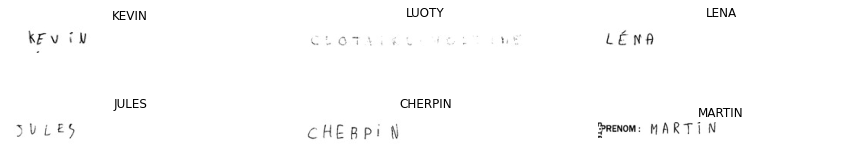

In [ ]:
test = pd.read_csv('/gdrive/MyDrive/CS331 - 18520186 - 18521027/Kaggle/written_name_test_v2.csv')

print('Test data shape:', test.shape) # Số dòng, số cột

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/gdrive/MyDrive/CS331 - 18520186 - 18521027/Kaggle/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

### Kết quả thực nghiệm

In [ ]:
import pandas as pd

results_dict={'Epochs':['5', '60', '100'],
              'Correct characters predicted':['8.61%', '88.67%', '83.19%'],
              'Correct words predicted':['0.00%', '74.62%', '69.47%'],
              'Time':['288s', '2800s', '4585s'],}
pd.DataFrame(results_dict)

,Epochs,Correct characters predicted,Correct words predicted,Time
0,5,8.61%,0.00%,288s
1,60,88.67%,74.62%,2800s
2,100,83.19%,69.47%,4585s


# **Các cách để cải thiện mô hình**

- Sử dụng nhiều mẫu huấn luyện hơn. Điều này sẽ giúp mô hình học và khái quát tốt hơn. Tôi chỉ sử dụng 10% ảnh của 2 tập train và test vì toàn bộ tập huấn luyện khi đưa vào hết sẽ tốn nhiều time và khiến bị đầy ổ đĩa.

- Có nhiều ảnh trong tập huấn luyện không dễ đọc đối với mắt người. Loại bỏ những hình ảnh như vậy sẽ giúp ích cho việc học của mô hình.